## Converting to Supergalactic Coordinates ##

we describe how we convert from RA, DEC, and redshift to SGX,SGY, and SGZ.

We try to reproduce the figures shown in Kim+2016

### load modules ###

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import os
import sys
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from mpl_toolkits.mplot3d import Axes3D
from astropy.cosmology import WMAP9 as cosmo
from astropy.constants import c
%matplotlib inline

/Users/kellywhalen/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Read in NSA catalog ###

In [4]:
#Get current path so program can tell if this is being run on Kelly's or Rose's computer
mypath=os.getcwd()
if mypath.find('rfinn') > -1:
    print "Running on Rose's computer"
    #agcfile='/Users/rfinn/idl/programs/idl_alfa/agctotal.sav'
    gitpath='/Users/rfinn/github/'
elif mypath.find('kelly') > -1:
    print "Running on Kellys's computer"
    gitpath='/Users/kellywhalen/Github/'
    nsapath = '/Users/kellywhalen/RESEARCH/NSA_table/'

#### READ IN DATA #####

#NSA Table
NSA_file = gitpath+'Virgo/nsa_v0_1_2_with_AGC.Virgo.fits'
NSA_file= nsapath + 'nsa_v0_1_2.fits'
nsa = fits.getdata(NSA_file)
nsadict=dict((a,b) for a,b in zip(nsa.NSAID,np.arange(len(nsa.NSAID))))

M100 = 141252 # NSA ID
M87 = 141541


Running on Kellys's computer


### Select Galaxies in the vicinity of Virgo ###

In [5]:
raflag = (nsa.RA > 115.) & (nsa.RA < 240.)
decflag= (nsa.DEC > -30.) & (nsa.DEC < 60.)
velflag =  (nsa.Z*3.e5 < 3000.) # & (nsa.Z*3.e5 > 1000.) 
vflag = raflag & decflag & velflag 

#nsa = nsa[vflag]

# define nsa RA and Dec as SkyCoord
nsa_sc = SkyCoord(nsa.RA*u.degree, nsa.DEC*u.degree)


##  FLOW MODEL  ##

convert RA and DEC to galactic
* l = galcoords.l.degree
* b = galcoords.b.degree



using mould+00 method to correct redshifts described in detail in appendix A

http://adsabs.harvard.edu/abs/2000ApJ...529..786M


### 1. Correct to centroid of the Local Group ###

In [6]:
# convert helio-centric velocity to units of km/s
V_H = nsa.Z*c.to('km/s')

# 1. correction of observed heliocentric velocity to centroid of local group
# VLG = VH - 79 cos l cos b + 296 sin l cos b - 36 sin b

V_LG = - 79.*u.km/u.second*np.cos(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) + 296.*u.km/u.second*np.sin(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) - 36.*u.km/u.second*np.sin(nsa_sc.galactic.b.radian)


### 2. Correction for Virgo infall

In [45]:
# from Mould+2000, ApJ, 529, 786
# not sure if we are using this equation exactly right

V_fid = 200.*u.km/u.second # infall of LG into Virgo?
# Virgo coordinates given by Mould+2000
Virgo = SkyCoord('12h28m19s', '+12d40m00s', frame='fk5',equinox='J1950.') # epoch = 1950
Virgo = Virgo.transform_to(FK5(equinox='J2000'))
### need to fix this to use spherical distance
#theta = np.sqrt((nsa_sc.ra.radian - Virgo.ra.radian)**2 + (nsa_sc.dec.radian - Virgo.dec.radian)**2)
theta = Virgo.separation(nsa_sc).radian 
# cluster radius in deg
gamma = 2.

V_a = 1035.*u.km/u.second # recession vel of Virgo from Mould+2000
V_o = nsa.Z*c.to('km/s') + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))

membflag = (nsa.Z*3.e5 < (3000-200*theta)) & (nsa.Z*3.e5 > (2*v_Virgo - (3000-200*theta)))& (theta < 10.)
V_infall = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))
V_infall[membflag] = 0.

### 3. Correction for GA infall ###

In [46]:
V_fid = 400.*u.km/u.second # infall of LG into Virgo?
# GA coordinates given by Mould+2000
GA = SkyCoord('13h20m00s', '+44d00m00s', frame='fk5',equinox='J1950.') # epoch = 1950
GA = GA.transform_to(FK5(equinox='J2000'))
theta = GA.separation(nsa_sc).radian
#theta = np.sqrt((nsa_sc.ra.radian - GA.ra.radian)**2 + (nsa_sc.dec.radian - GA.dec.radian)**2)

gamma = 2.
V_a = 4380.*u.km/u.second # recession vel of Virgo from Mould+2000
V_o = nsa.Z*c.to('km/s') + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
V_GA = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))

### 4. Correction for Shapley supercluster infall. ###

In [47]:
# Final, correction cosmic velocity is
#
#  Vcosmic = VH + Vc,LG + Vin,Virgo + Vin,GA + Vin,Shap + ...

# ## Tranforming to Supergalactic Coordinates##
# 
# Looking to match the plots shown in Kim+2016
# 
# https://arxiv.org/abs/1611.00437

### Caveats for Corrections ###

The flow corrections will blow up as the galaxy gets close to the attractor, so we don't want to apply the Virgo correction for galaxies that are members of Virgo.

So - which galaxies are members of Virgo?  Let's make a phase space plot and see what it looks like.

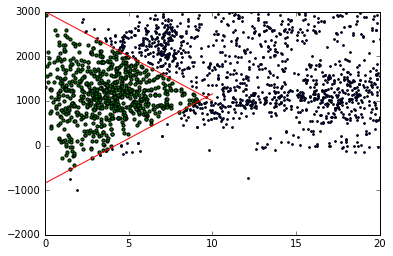

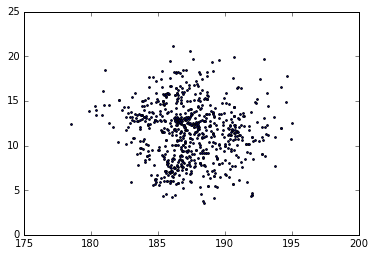

In [44]:

# Virgo coordinates given by Mould+2000
Virgo = SkyCoord('12h28m19s', '+12d40m00s', frame='fk5',equinox='J1950.') # epoch = 1950
Virgo = Virgo.transform_to(FK5(equinox='J2000'))
v_Virgo = 1079. # recession velocity of Virgo in km/s
theta = Virgo.separation(nsa_sc).degree 
deltav = nsa.Z*3.e5# - v_Virgo
plt.figure()
plt.scatter(theta[vflag],deltav[vflag],s=3)
plt.axis([0,20,-2000,3000])
xl=np.linspace(0,10,100)
yl = 3000-200*xl
plt.plot(xl,yl,'r-')
yl = 2*v_Virgo - (3000-200*xl)
plt.plot(xl,yl,'r-')


# member flag

membflag = (nsa.Z*3.e5 < (3000-200*theta)) & (nsa.Z*3.e5 > (2*v_Virgo - (3000-200*theta)))& (theta < 10.)
plt.scatter(theta[vflag & membflag],deltav[vflag & membflag],s=10,c='g')


plt.figure()
#plt.scatter(nsa_sc.ra.deg[vflag]-Virgo.ra.deg,nsa_sc.dec.deg[vflag]-(-5.).deg,s=3)
plt.scatter(nsa_sc.ra.deg[vflag & membflag],nsa_sc.dec.deg[vflag& membflag],s=3)

In [11]:
print Virgo.ra.deg, Virgo.dec.deg


187.711685542 12.3905945296


In [12]:
sum(membflag)

738

### Add up all of the corrections ###

In [48]:
#Plot of Virgo Cluster in galactic coordinates
V_cosmic = V_H + V_LG + V_infall #+V_GA
V = V_cosmic

### Convert to Supergalactic X, Y, and X coordinates###

In [49]:
#SGX = V/cosmo.H(0)*np.cos(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
#SGY = V/cosmo.H(0)*np.sin(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
#SGZ = V/cosmo.H(0)*np.sin(nsa_sc.supergalactic.sgb.radian)


# using H0 = 74 to match Kim+2016 paper
H0 = 74.*u.km/u.second/u.Mpc
SGX = V/H0*np.cos(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGY = V/H0*np.sin(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGZ = V/H0*np.sin(nsa_sc.supergalactic.sgb.radian)

### Subtract the Position of Virgo ###

In [50]:
distance_to_virgo = 16.5*u.Mpc #Mpc
SGX_Virgo = distance_to_virgo*np.cos(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGY_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGZ_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgb.radian)

# difference 
DSGX = SGX - SGX_Virgo
DSGY = SGY - SGY_Virgo
DSGZ = SGZ - SGZ_Virgo


### Various cuts used by Kim+2016 ###

In [51]:
# don't use objects w/in 3.6 Mpc of Virgo (Kim+2016)

dist = np.sqrt(DSGX**2 + DSGY**2 + DSGZ**2) 
dist_flag = dist.value > 3.6


# In[7]:

kim_vflag = nsa.Z*3.e5 < 6000.  
kim_raflag = (nsa.RA > 115.) & (nsa.RA < 240.)
kim_decflag = (nsa.DEC > -35.) & (nsa.DEC < 60.)
kim_flag = kim_vflag & kim_raflag & kim_decflag #& dist_flag 

d_split = 16.
#In front of cluster
SGYfront_flag = (SGY > 4. * u.Mpc) & (SGY < d_split * u.Mpc)
SGYback_flag = (SGY > d_split * u.Mpc) & (SGY < 40. * u.Mpc)
#SGYback_flag = (SGY > 21. * u.Mpc) & (SGY < 27. * u.Mpc)

SGYvirgo =  (SGY > 4.*u.Mpc) & (SGY < d_split*u.Mpc)

In [52]:
print sum(dist_flag), len(dist_flag)

144874 145155


(array([    6.,   124.,   382.,   841.,  1111.,   884.,   649.,   618.,
          532.,   470.,   493.,   489.]),
 array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36]),
 <a list of 12 Patch objects>)

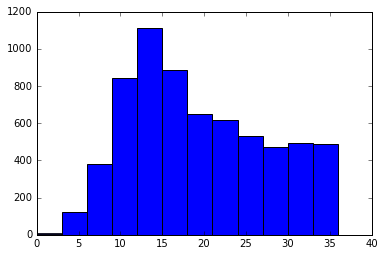

In [18]:
plt.figure()
plt.hist(dist,bins=np.arange(0,39,3))

## Making Plots ##

In [53]:
def plotxzplane(flag1, flag2):
    '''
    flag1 = things around virgo
    flag2 = things behind virgo
    '''
    plt.figure(figsize=(6,4))
    plt.scatter(SGX[flag1],SGZ[flag1],alpha=.5,c=SGY[flag1],vmin=0,vmax=36)
    #plt.scatter(DSGX,DSGZ,alpha=.5,c=DSGY)
    plt.colorbar(fraction=.08,label='SGY (Mpc)')
    plt.subplots_adjust(bottom=.15)
    #plt.axis([-15,10,-10,20])
    plt.xlabel('$SGX \ (Mpc)$')
    plt.ylabel('$SGZ \ (Mpc)$')
    plt.title('Region around Virgo Cluster (Compare to Kim Fig 2)')
    plt.axis([-15,18,-17,12])
    plt.axvline(x=0,ls='--',color='k')
    plt.axhline(y=0,ls='--',color='k')

    ## plt.figure(figsize=(6,4))
    ## plt.scatter(SGX[kim_flag & SGYfront_flag],SGZ[kim_flag & SGYfront_flag],alpha=.5,c=SGY[kim_flag & SGYfront_flag])
    ## plt.colorbar(fraction=.08)
    ## plt.axis([-15,10,-10,20])
    ## plt.xlabel('SGX (Mpc)')
    ## plt.ylabel('SGZ (Mpc)')
    ## plt.title('Region In Front of Virgo Cluster')
    ## plt.axvline(x=0,ls='--',color='k')
    ## plt.axhline(y=0,ls='--',color='k')

    plt.figure(figsize=(6,4))
    plt.subplots_adjust(bottom=.15)
    plt.scatter(SGX[flag2],SGZ[flag2],alpha=.5,c=SGY[flag2],vmin=0,vmax=36)
    #plt.scatter(SGX[NGCfilament],SGZ[NGCfilament],alpha=1,c=SGY[NGCfilament],s=60)
    plt.colorbar(fraction=.08,label='SGY (Mpc)')
    plt.axis([-15,10,-10,20])
    plt.xlabel('$SGX \ (Mpc)$')
    plt.ylabel('$SGZ \ (Mpc)$')
    plt.title('Region Behind Virgo Cluster (Compare to Kim Fig 3)')
    plt.axvline(x=0,ls='--',color='k')
    plt.axhline(y=0,ls='--',color='k')
    plt.axis([-18,7,-10,14])


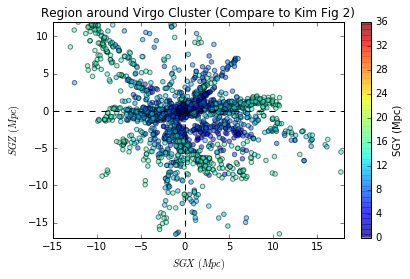

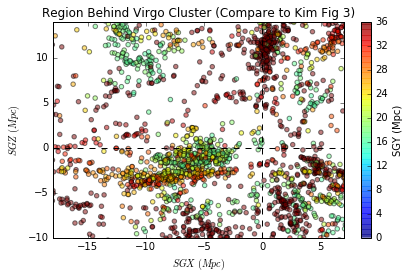

In [54]:
flag1 = kim_flag = kim_vflag & kim_raflag & kim_decflag & dist_flag & (SGY < 16.*u.Mpc)& (SGY > 0.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > 16.*u.Mpc)
plotxzplane(flag1,flag2)

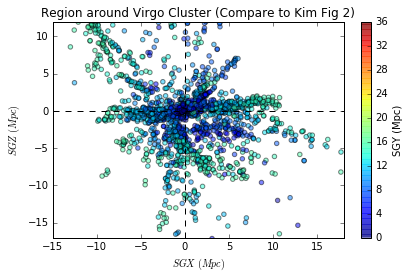

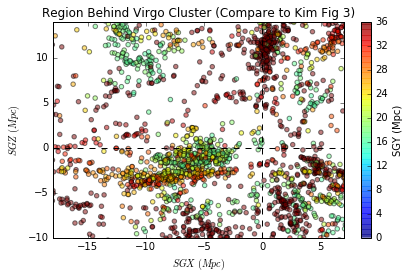

In [55]:
flag1 = kim_flag = kim_vflag  & kim_decflag & dist_flag & (SGY < 16.*u.Mpc) & (SGY > 0.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > 16.*u.Mpc)
plotxzplane(flag1,flag2)

## RA and DEC cuts don't affect the plots
## the SGY cut does affect the plot

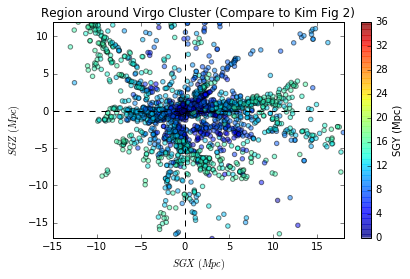

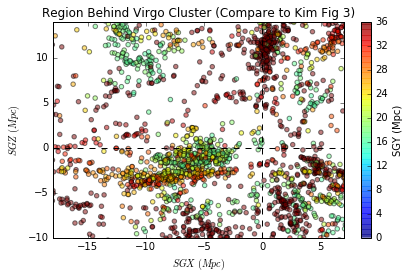

In [56]:
flag1 = kim_flag = kim_vflag & dist_flag & (SGY < 16.*u.Mpc) & (SGY > 0.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > 16.*u.Mpc)
plotxzplane(flag1,flag2)

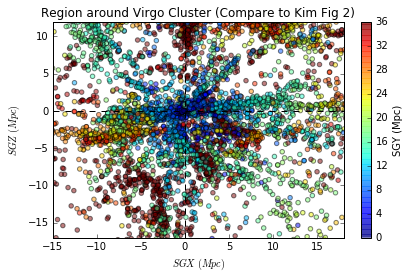

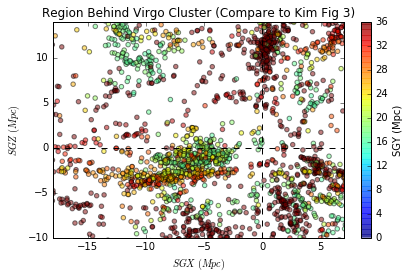

In [57]:
flag1 = kim_flag = kim_vflag & dist_flag & (SGY > 0.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > 16.*u.Mpc)
plotxzplane(flag1,flag2)

## We are not using the SGY cut on the first plot.
## all of the extra points are from things in front of or behind Virgo

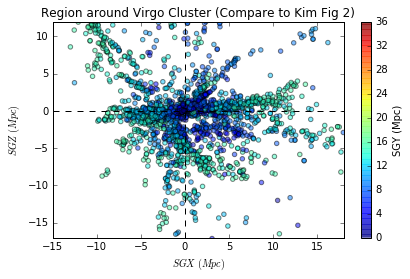

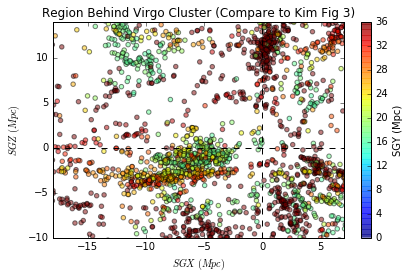

In [58]:
flag1 = kim_flag = kim_vflag  & (SGY < 16.*u.Mpc) & (SGY > 0.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > 16.*u.Mpc)
plotxzplane(flag1,flag2)

## 16 Mpc cut is removing lots of stuff on lower left quadrant
## indicates that our SGY values are off from Kim+2016 values
## going to try adjusting the 16 Mpc cut

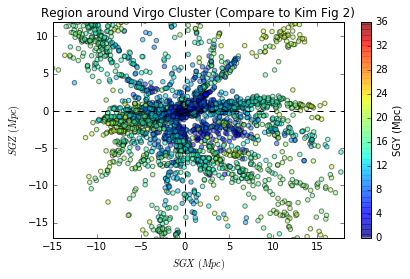

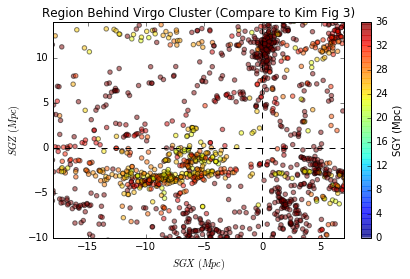

In [59]:
SGY_cut = 22.
flag1 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY < SGY_cut*u.Mpc) & (SGY > 0.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > SGY_cut*u.Mpc)
plotxzplane(flag1,flag2)


In [60]:
# the dictionary will return the index for a galaxy with the matching NSAID
# for example, for NGC 5353
print 'index = ',nsadict[56483]

# to get its recession velocity
print 'recession velocity = ',nsa.Z[nsadict[56483]]*3.e5

# to get its recession velocity
print 'SGY = ',SGY[nsadict[56483]]


index =  50826
recession velocity =  2365.47142267
SGY =  29.9089018702 Mpc
